<a href="https://colab.research.google.com/github/TrueBalkar/Test_WT/blob/main/Exploratory%20data%20analysis%20of%20the%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
! pip uninstall -y Kaggle
! pip install Kaggle
from google.colab import files
files.upload()

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
  Using cached kaggle-1.5.12-py3-none-any.whl


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"a12000","key":"48ae0a63ffdcce9a7d1a9ace822e5ff4"}'}

In [9]:
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [10]:
! kaggle competitions download airbus-ship-detection

100% 28.6G/28.6G [09:41<00:00, 58.6MB/s]
100% 28.6G/28.6G [09:41<00:00, 52.8MB/s]


In [ ]:
! unzip /content/airbus-ship-detection

In [12]:
! rm airbus-ship-detection.zip

In [13]:
! pip install patchify
! pip install segmentation_models

     |████████████████████████████████| 50 kB 7.1 MB/s 


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import shutil
from keras.layers import Conv2D, Input, Dropout, concatenate, UpSampling2D, \
                         MaxPooling2D, BatchNormalization, Activation, Conv2DTranspose
from keras import Model, backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `keras` framework.


In [61]:
# Load data
masks = pd.read_csv(r"/content/train_ship_segmentations_v2.csv")
print(f"train_ship_segmentations_v2.csv:\n\n{masks.head(10)}\n\n")

masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
print(f"{unique_img_ids}\n")
unique_img_ids['is_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)

print(f"Count of images with/withot ships \n{unique_img_ids['is_ship'].value_counts()}\n\n")
print(f"Count of images with number (0, 1, 2 etc.) of ships \n{unique_img_ids['ships'].value_counts()}\n\n")

train_ship_segmentations_v2.csv:

         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8  0001b1832.jpg                                                NaN
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...


              ImageId  ships
0       00003e153.jpg      0
1       0001124c7.jpg      0
2       000155de5.jpg      1
3       000194a2d.jpg      5
4       0001b1832.jpg      0
...               ...    ...
192551  fffed

In [16]:
print(unique_img_ids)

              ImageId  ships  is_ship
0       00003e153.jpg      0      0.0
1       0001124c7.jpg      0      0.0
2       000155de5.jpg      1      1.0
3       000194a2d.jpg      5      1.0
4       0001b1832.jpg      0      0.0
...               ...    ...      ...
192551  fffedbb6b.jpg      0      0.0
192552  ffff2aa57.jpg      0      0.0
192553  ffff6e525.jpg      0      0.0
192554  ffffc50b4.jpg      0      0.0
192555  ffffe97f3.jpg      0      0.0

[192556 rows x 3 columns]


In [17]:
# Function to encode mask
def rle_decode(mask_rle, IMG_SIZE = (768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 255 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(IMG_SIZE[0]*IMG_SIZE[1])
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 255
    return img.reshape(IMG_SIZE).T

In [18]:
# Here you can choose how much ships do you want to see on an image - variable 'num_ships'
num_ships = 1
print(f"ImageId's with {num_ships} ships on it \n{unique_img_ids.loc[unique_img_ids.ships == num_ships, 'ImageId'].head(5)}")

ImageId's with 1 ships on it 
2     000155de5.jpg
9     00031f145.jpg
12    00053c6ba.jpg
16    0005d6d95.jpg
17    0006c52e8.jpg
Name: ImageId, dtype: object


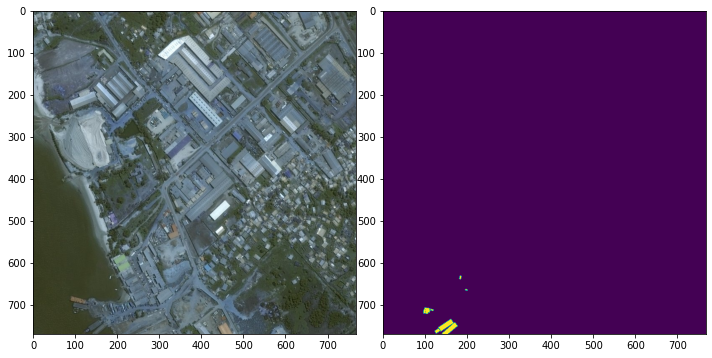

In [62]:
def display(ImageId):

    img = cv2.imread('/content/train_v2/' + ImageId)
    img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask, (768, 768))

    fig, axarr = plt.subplots(1, 2, figsize=(10, 20))
    axarr[0].imshow(img)
    axarr[1].imshow(all_masks)
    plt.tight_layout(h_pad=0.1, w_pad=0.1) # to adjust automatically axis to subplot area
    plt.show()

display('00021ddc3.jpg')